In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import ColumnDataSource
from statsmodels.formula.api import ols



sns.set_theme(style="whitegrid")

In [2]:
#load the dataset
df = pd.read_csv("social_media_engagement_dataset.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   platform         10000 non-null  object 
 1   post_type        10000 non-null  object 
 2   post_length      10000 non-null  int64  
 3   views            10000 non-null  int64  
 4   likes            10000 non-null  int64  
 5   comments         10000 non-null  int64  
 6   shares           10000 non-null  int64  
 7   engagement_rate  10000 non-null  float64
dtypes: float64(1), int64(5), object(2)
memory usage: 625.1+ KB
None


In [3]:
#handling missing values
print(df.isnull().sum())

numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

categorical_columns = df.select_dtypes(include=['object', 'string']).columns
for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

print(df.isnull().sum())

platform           0
post_type          0
post_length        0
views              0
likes              0
comments           0
shares             0
engagement_rate    0
dtype: int64
platform           0
post_type          0
post_length        0
views              0
likes              0
comments           0
shares             0
engagement_rate    0
dtype: int64


In [4]:
#create a new column for total engagement
df['Total_Engagement'] = df['likes'] + df['comments'] + df['shares']

In [5]:
#encoding categorical variables
data_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=False)
print(data_encoded.head())

   post_length   views  likes  comments  shares  engagement_rate  \
0           62   91660   2968       276     346         0.039166   
1          104  113115   4164       632     406         0.045989   
2           46   36043   3125       188     100         0.094692   
3           39  124886   5970       948     578         0.060023   
4           42   82831   8212      1104     334         0.116502   

   Total_Engagement  platform_Facebook  platform_Instagram  platform_Twitter  \
0              3590               True               False             False   
1              5202              False                True             False   
2              3413               True               False             False   
3              7496               True               False             False   
4              9650              False                True             False   

   post_type_Image  post_type_Text  post_type_Video  
0            False            True            False  
1 

In [6]:
#exploratory data analysis
# Overall summary

print("Total Engagement Summary")
print(df['Total_Engagement'].describe(), "\n")

print("Summary by Post Type")
content_summary = df.groupby('post_type')['Total_Engagement'].describe()
print(content_summary, "\n")

print("Summary by Platform")
platform_summary = df.groupby('platform')['Total_Engagement'].describe()
print(platform_summary, "\n")

print("Summary by Platform and Content Type")
overall_summary = df.groupby(['platform','post_type'])['Total_Engagement'].describe()
print(overall_summary, "\n")



Total Engagement Summary
count    10000.000000
mean      8514.764700
std       6898.648386
min         43.000000
25%       3029.750000
50%       6732.000000
75%      12391.250000
max      38270.000000
Name: Total_Engagement, dtype: float64 

Summary by Post Type
            count         mean          std   min      25%     50%       75%  \
post_type                                                                      
Image      3370.0  8591.758160  6871.566533  43.0  3120.25  6921.0  12509.75   
Text       3297.0  8402.726721  6881.958900  84.0  2982.00  6591.0  12344.00   
Video      3333.0  8547.744374  6942.980767  60.0  2990.00  6780.0  12317.00   

               max  
post_type           
Image      36004.0  
Text       38270.0  
Video      34311.0   

Summary by Platform
            count          mean          std   min      25%     50%      75%  \
platform                                                                       
Facebook   3299.0   8593.683844  6675.844592  60.

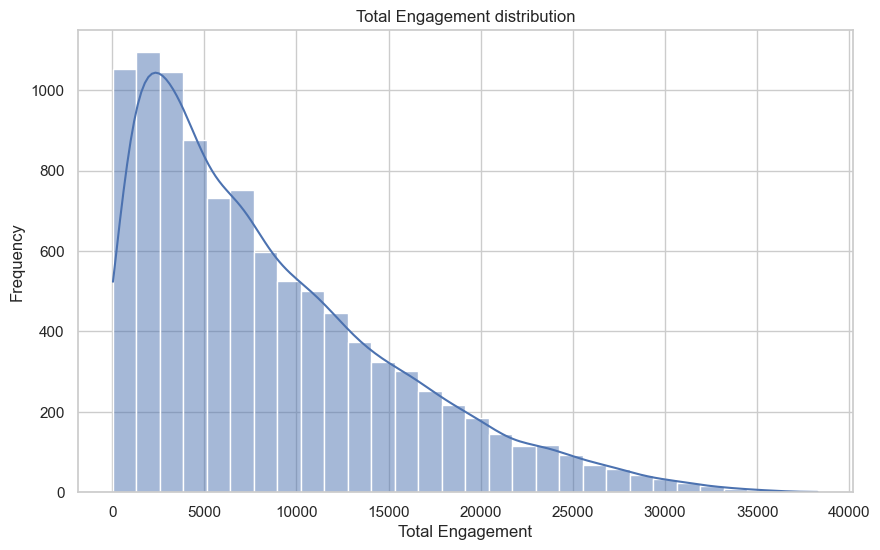

In [7]:
#total engagement distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Total_Engagement'], bins=30, kde=True)
plt.title('Total Engagement distribution')
plt.xlabel('Total Engagement')
plt.ylabel('Frequency')
plt.show()

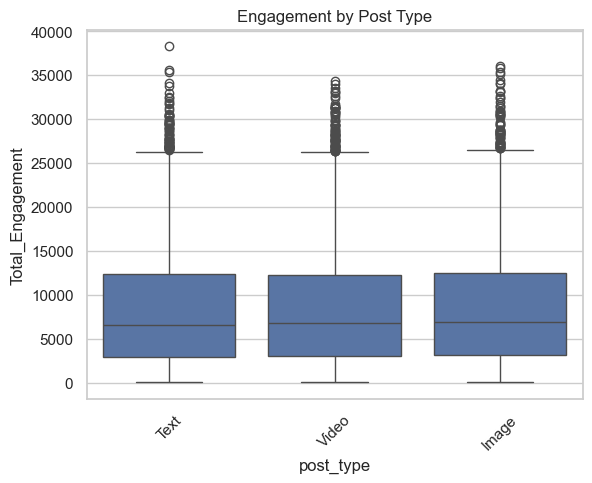

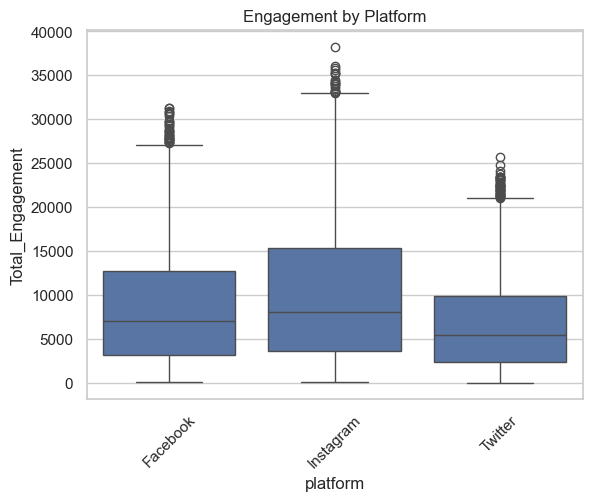

In [8]:
#user engagement by post type
plt.figure()
sns.boxplot(x='post_type', y='Total_Engagement', data=df)
plt.title("Engagement by Post Type")
plt.xticks(rotation=45)
plt.show()

#user engagement by platform
plt.figure()
sns.boxplot(x='platform', y='Total_Engagement', data=df)
plt.title("Engagement by Platform")
plt.xticks(rotation=45)
plt.show()

  post_type   platform  Total_Engagement
0     Image   Facebook       8884.993728
1     Image  Instagram      10273.122650
2     Image    Twitter       6652.149516
3      Text   Facebook       8431.325688
4      Text  Instagram      10048.198556
5      Text    Twitter       6715.414923
6     Video   Facebook       8458.156450
7     Video  Instagram      10415.787422
8     Video    Twitter       6737.572457


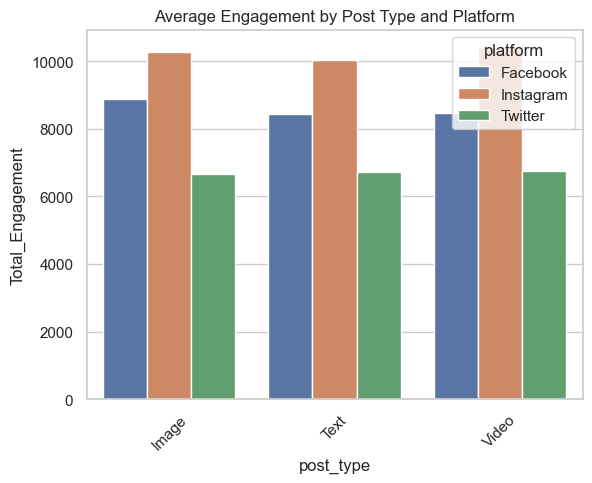

In [9]:
#average engagement by content type and platform
grouped = df.groupby(['post_type', 'platform'])['Total_Engagement'].mean().reset_index()
print(grouped)
plt.figure()
sns.barplot(x='post_type', y='Total_Engagement', hue='platform', data=grouped)
plt.title("Average Engagement by Post Type and Platform")
plt.xticks(rotation=45)
plt.show()

Correlation with Total Engagement:
Total_Engagement      1.000000
likes                 0.997245
comments              0.901950
shares                0.849983
views                 0.737645
engagement_rate       0.590014
platform_Instagram    0.178372
post_length           0.008075
platform_Facebook     0.008027
post_type_Image       0.007957
post_type_Video       0.003380
post_type_Text       -0.011391
platform_Twitter     -0.186462
Name: Total_Engagement, dtype: float64


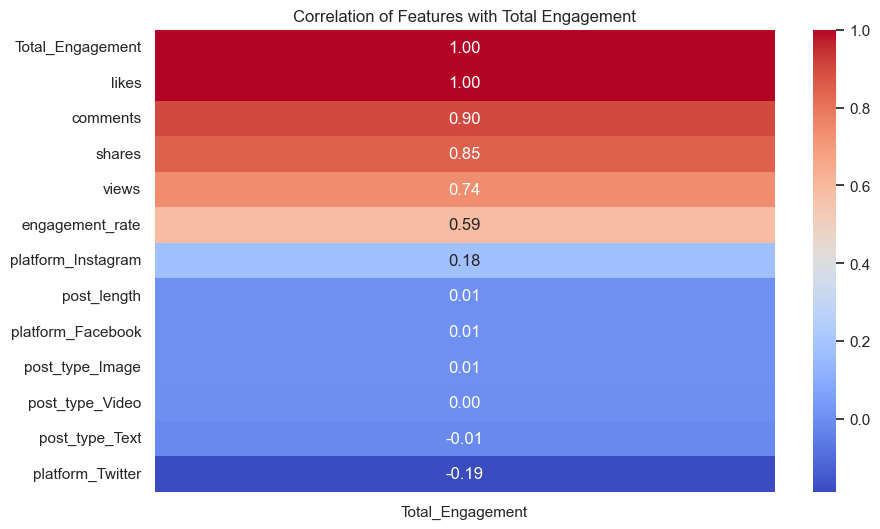

In [10]:
# Calculate correlation matrix
correlation_matrix = data_encoded.corr()

engagement_corr = correlation_matrix['Total_Engagement'].sort_values(ascending=False)

print("Correlation with Total Engagement:")
print(engagement_corr)

plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix[['Total_Engagement']].sort_values(by='Total_Engagement', ascending=False), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Features with Total Engagement")
plt.show()

In [11]:
model = ols('Total_Engagement ~ C(post_type) + C(platform) + C(post_type):C(platform)',data=df).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print("Two Way ANOVA analysis for Post Type and Platform.")
print(anova_table)

platforms = df['platform'].unique()

for plat in platforms:
    print(f" One Way ANOVA for Post Type on {plat}")
    df_platform = df[df['platform'] == plat]
    model_platform = ols('Total_Engagement ~ C(post_type)', data=df_platform).fit()
    anova_platform = sm.stats.anova_lm(model_platform, typ=2)
    print(anova_platform)

post_types = df['post_type'].unique()

for pt in post_types:
    print(f"\n One Way ANOVA for Platform on {pt} posts")
    df_postType = df[df['post_type'] == pt]
    model_postType = ols('Total_Engagement ~ C(platform)', data=df_postType).fit()
    anova_postType = sm.stats.anova_lm(model_postType, typ=2)
    print(anova_postType)

combination_means = df.groupby(['platform','post_type'])['Total_Engagement'].mean()
best_combo = combination_means.idxmax()
best_value = combination_means.max()

print("\nBest Platform and Post Type Combination")
print(f"Platform: {best_combo[0]}")
print(f"Post Type: {best_combo[1]}")


Two Way ANOVA analysis for Post Type and Platform.
                                sum_sq      df           F        PR(>F)
C(post_type)              7.267253e+07     2.0    0.798669  4.499563e-01
C(platform)               2.109792e+10     2.0  231.865448  3.708252e-99
C(post_type):C(platform)  1.519856e+08     4.0    0.835158  5.025555e-01
Residual                  4.545510e+11  9991.0         NaN           NaN
 One Way ANOVA for Post Type on Facebook
                    sum_sq      df         F    PR(>F)
C(post_type)  1.435138e+08     2.0  1.610691  0.199907
Residual      1.468381e+11  3296.0       NaN       NaN
 One Way ANOVA for Post Type on Instagram
                    sum_sq      df         F    PR(>F)
C(post_type)  7.671684e+07     2.0  0.598984  0.549428
Residual      2.145953e+11  3351.0       NaN       NaN
 One Way ANOVA for Post Type on Twitter
                    sum_sq      df         F    PR(>F)
C(post_type)  4.427417e+06     2.0  0.079498  0.923582
Residual      9.31176

In [12]:
#Regression analysis
predictors = data_encoded.drop(columns=['Total_Engagement', 'likes', 'comments', 'shares']).astype(float)
target = data_encoded['Total_Engagement']
X = sm.add_constant(predictors)
model = sm.OLS(target, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Total_Engagement   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                 1.046e+04
Date:                Mon, 16 Feb 2026   Prob (F-statistic):               0.00
Time:                        21:46:54   Log-Likelihood:                -91981.
No. Observations:               10000   AIC:                         1.840e+05
Df Residuals:                    9992   BIC:                         1.840e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -5103.5078     49